# A Pairs Trading strategy boosted with AI

This notebook explores a pairs trading strategy fueled by AI innovative techniques. This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

## Dependencies

This notebook requires code from:

Python files:
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_ForecastingTrader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

Pickle files:
- pickle file containing pairs to be traded (obtained from running `PairsTrading_CommodityETFs-Clustering.ipynb`)

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples, rather than coding the strategies theirselves. Please look into the files menitoned above for more detailed info on how the functions are built.

### Import Libraries

In [2]:
import numpy as np
np.random.seed(1) # NumPy
import random
random.seed(3) # Python
import tensorflow as tf
tf.set_random_seed(2) # Tensorflow
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
tf.__version__

'1.6.0'

In [4]:
import warnings
warnings.filterwarnings('ignore')

from pylab import *

import pandas as pd
import pickle
import time
import sys
import json
import os

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, GRU, Dropout, TimeDistributed
from keras.optimizers import SGD, Adam
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping, ProgbarLogger

In [5]:
config_file = 'config/config_commodities_2010_2019.json'

In [6]:
pd.__version__

'0.24.2'

### Import Configurations

In [7]:
with open(config_file, 'r') as f:
    config = json.load(f)

### Import Classes

In [8]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor, class_ForecastingTrader
%autoreload 1

In [9]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()
forecasting_trader = class_ForecastingTrader.ForecastingTrader()

# Retrieve prices data set

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [10]:
# intraday
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_intraday_interpolated_screened_no_outliers.pickle')

# inter day
#df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_interpolated_screened')

In [11]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            ('01-01-2009',
                                                             '31-12-2017'),
                                                            ('01-01-2018',
                                                             '31-12-2018'),
                                                            remove_nan=True)

Total of 59 tickers
Total of 58 tickers after removing tickers with Nan values


In [12]:
len(df_prices_train)+len(df_prices_test)

195414

# Load Pairs

In [13]:
# intra day
#with open('data/etfs/pickle/pairs_unfiltered_intraday.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

#with open('data/etfs/pickle/pairs_category_intraday.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

with open('models_copy/mlp_7_pairs/pairs_unsupervised_learning_intraday.pickle', 'rb') as handle:
#with open('models_copy/mlp_4_pairs_by_mstk/pairs_unsupervised_learning_intraday.pickle', 'rb') as handle:
#with open('data/etfs/pickle/pairs_unsupervised_learning_intraday.pickle', 'rb') as handle:
    pairs = pickle.load(handle)
    
# interday  
#with open('data/etfs/pickle/pairs_unfiltered_interday.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

#with open('data/etfs/pickle/pairs_category_interday.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

#with open('data/etfs/pickle/pairs_unsupervised_learning_interday.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

In [14]:
# intraday
n_years_train = round(len(df_prices_train)/(240*78))

# interday
#n_years_train = round(len(df_prices_train)/(240))

n_years_train

9

# The ideal scenario - forecasting accuracy of 100%

In [23]:
# define data size - select one year for validation
train_val_split = '2017-01-01' # initial date
cumret_pairs = []    
summaries = []
val=True
for i in range(len(pairs)):
    example = pairs[i]
    example_spread = example[2]['spread']

    if val:
        # normalize data
        standardization_dict = {'mean':example_spread[:train_val_split].mean(),
                                'std':np.std(example_spread[:train_val_split])}
        example_spread_norm = (example_spread - standardization_dict['mean'])/standardization_dict['std']
        example_spread_destandardized = forecasting_trader.destandardize(example_spread_norm,
                                                                         standardization_dict['mean'],
                                                                         standardization_dict['std'])

        # spread validation
        spread_val = example_spread[train_val_split:] 
        predictions = forecasting_trader.destandardize(example_spread_norm[train_val_split:],
                                                       standardization_dict['mean'],
                                                       standardization_dict['std'])
    else:
        spread_val = pairs[i][2]['Y_test']-pairs[i][2]['coint_coef']*pairs[i][2]['X_test']
        predictions = spread_val

    ret_example, cumret_example, summary_example = forecasting_trader.forecast_spread_trading(
                                                                       X=example[2]['X_train'][train_val_split:],
                                                                       Y=example[2]['Y_train'][train_val_split:],
                                                                       spread_test=spread_val,
                                                                       spread_train=example_spread[:train_val_split],
                                                                       beta=pairs[i][2]['coint_coef'], 
                                                                       predictions=predictions,
                                                                       lag=1,
                                                                       low_quantile=0.20,
                                                                       high_quantile=0.80)
    print('Pair {}: Accumulated return: {}%'.format(i,cumret_example[-1]*100))
    cumret_pairs.append(cumret_example[-1]*100)
    summaries.append(summary_example)
    #cumret_example.plot()
print('\nAverage annual ROI: {:.2f}'.format(np.mean(cumret_pairs)))

Long threshold: 5.00
Short threshold: -5.00
Pair 0: Accumulated return: 107.83469517818914%
Long threshold: 5.00
Short threshold: -5.00
Pair 1: Accumulated return: 49.61677417471832%
Long threshold: 16.14
Short threshold: -15.94
Pair 2: Accumulated return: -27.157444561514698%
Long threshold: 5.00
Short threshold: -5.00
Pair 3: Accumulated return: 114.84477459172649%
Long threshold: 17.11
Short threshold: -15.80
Pair 4: Accumulated return: 23.11201784890544%
Long threshold: 27.17
Short threshold: -23.97
Pair 5: Accumulated return: -68.69037598488028%
Long threshold: 5.00
Short threshold: -5.00
Pair 6: Accumulated return: 392.96974750771085%

Average annual ROI: 84.65


In [25]:
# define data size - select one year for validation
train_val_split = '2017-01-01' # initial date
cumret_pairs = []    
summaries = []
val=False
for i in range(len(pairs)):
    example = pairs[i]
    example_spread = example[2]['spread']

    if val:
        # normalize data
        standardization_dict = {'mean':example_spread[:train_val_split].mean(),
                                'std':np.std(example_spread[:train_val_split])}
        example_spread_norm = (example_spread - standardization_dict['mean'])/standardization_dict['std']
        example_spread_destandardized = forecasting_trader.destandardize(example_spread_norm,
                                                                         standardization_dict['mean'],
                                                                         standardization_dict['std'])

        # spread validation
        spread_val = example_spread[train_val_split:] 
        predictions = forecasting_trader.destandardize(example_spread_norm[train_val_split:],
                                                       standardization_dict['mean'],
                                                       standardization_dict['std'])
    else:
        spread_val = pairs[i][2]['Y_test']-pairs[i][2]['coint_coef']*pairs[i][2]['X_test']
        predictions = spread_val

    ret_example, cumret_example, summary_example = forecasting_trader.forecast_spread_trading(
                                                                       X=example[2]['X_test'],
                                                                       Y=example[2]['Y_test'],
                                                                       spread_test=spread_val,
                                                                       spread_train=example_spread[:train_val_split],
                                                                       beta=pairs[i][2]['coint_coef'], 
                                                                       predictions=predictions,
                                                                       lag=1,
                                                                       low_quantile=0.20,
                                                                       high_quantile=0.80)
    print('Pair {}: Accumulated return: {}%'.format(i,cumret_example[-1]*100))
    cumret_pairs.append(cumret_example[-1]*100)
    summaries.append(summary_example)
    #cumret_example.plot()
print('\nAverage annual ROI: {:.2f}'.format(np.mean(cumret_pairs)))

Long threshold: 5.00
Short threshold: -5.00
Pair 0: Accumulated return: 150.6634462297415%
Long threshold: 5.00
Short threshold: -5.00
Pair 1: Accumulated return: 34.26871297908522%
Long threshold: 16.14
Short threshold: -15.94
Pair 2: Accumulated return: 39.23143433939953%
Long threshold: 5.00
Short threshold: -5.00
Pair 3: Accumulated return: 133.81908380203276%
Long threshold: 17.11
Short threshold: -15.80
Pair 4: Accumulated return: 12.945890654930148%
Long threshold: 27.17
Short threshold: -23.97
Pair 5: Accumulated return: 58.88501329456162%
Long threshold: 5.00
Short threshold: -5.00
Pair 6: Accumulated return: 87.98916485901759%

Average annual ROI: 73.97


In [43]:
from statsmodels.tsa.arima_model import ARIMA
    
def predict(coef, history, flag):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
        
    return yhat

def static_ARIMA(spread_train, spread_test, p, d, q):

    # normalize data
    scaler = MinMaxScaler(feature_range = (0, 1))
    spread_train_norm = scaler.fit_transform(spread_train.values.reshape(spread_train.shape[0],1)) 
    spread_train_norm = pd.Series(data=spread_train_norm.flatten(), index=spread_train.index)

    # spread test
    spread_test_norm = scaler.transform(spread_test.values.reshape(spread_test.shape[0],1)) 
    spread_test_norm = pd.Series(data=spread_test_norm.flatten(), index=spread_test.index)

    train, test = spread_train_norm.values, spread_test_norm.values
    history = np.asarray(train)
    predictions = list()
    residuals = list()
    
    #print('Start model fitting...')
    start = time.time()
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit(transparams=False, tol=0.0001, trend='nc', disp=1)
    ar_coef, ma_coef = model_fit.arparams, model_fit.maparams 
    resid = model_fit.resid 
    end = time.time()
    #print('Finished model fitting... Time elapsed: ',(end - start))
    print(model_fit.summary())

    # test data
    residuals.extend(resid)
    for t in range(len(test)): 
        yhat = predict(ar_coef, history, 'ar') + predict(ma_coef, residuals, 'ma')
        predictions.append(yhat)
        obs = test[t]
        history = np.append(history, obs)
        residuals.append(obs - yhat)
        sys.stdout.write('\r'+str(t))
        
    # destandardize
    predictions = np.array(predictions)
    predictions =  scaler.inverse_transform(predictions.reshape(predictions.shape[0],1)).flatten()
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)
    print('\nVal MSE: %.3E' % mse)
    print('Val RMSE: %.3E'% rmse)
    
    # plot
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()
    
    predictions = pd.Series(data=predictions, index=spread_test.index, name='ARMA_predictions')
    
    return predictions, mse

# ARMA/ARIMA Model

Contrarily from the Neural Network models, predicting the time step t+n implies training until t+n-1, due to the residuals that must be inferred.

Pair: 2/7

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:               176022
Model:                     ARMA(5, 4)   Log Likelihood              677379.076
Method:                       css-mle   S.D. of innovations                nan
Date:                Thu, 04 Jul 2019   AIC                       -1354738.153
Time:                        15:26:48   BIC                       -1354637.369
Sample:                             0   HQIC                      -1354708.325
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        1.3506   9.07e-06   1.49e+05      0.000       1.351       1.351
ar.L2.y       -0.0199        nan        nan        nan         nan         nan
ar.L3.y       -0.1947        nan        nan        n

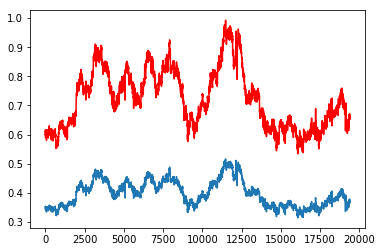

Pair: 3/7

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:               176022
Model:                     ARMA(5, 4)   Log Likelihood              603179.517
Method:                       css-mle   S.D. of innovations                nan
Date:                Thu, 04 Jul 2019   AIC                       -1206339.034
Time:                        15:33:05   BIC                       -1206238.250
Sample:                             0   HQIC                      -1206309.205
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        1.2597   1.17e-05   1.07e+05      0.000       1.260       1.260
ar.L2.y       -0.1524   4.95e-05  -3078.032      0.000      -0.152      -0.152
ar.L3.y       -0.0025      0.114     -0.022      0.9

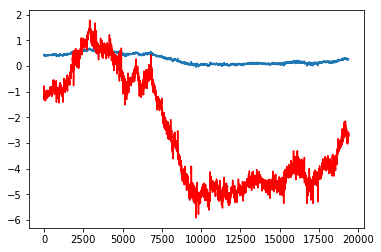

Pair: 4/7

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:               176022
Model:                     ARMA(5, 4)   Log Likelihood              727204.055
Method:                       css-mle   S.D. of innovations                nan
Date:                Thu, 04 Jul 2019   AIC                       -1454388.109
Time:                        15:39:38   BIC                       -1454287.326
Sample:                             0   HQIC                      -1454358.281
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        1.4157   5.69e-06   2.49e+05      0.000       1.416       1.416
ar.L2.y       -0.3844   4.28e-06  -8.97e+04      0.000      -0.384      -0.384
ar.L3.y        0.0680        nan        nan        n

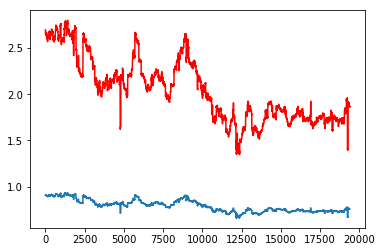

Pair: 5/7

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:               176022
Model:                     ARMA(5, 4)   Log Likelihood              600415.193
Method:                       css-mle   S.D. of innovations                nan
Date:                Thu, 04 Jul 2019   AIC                       -1200810.386
Time:                        15:46:16   BIC                       -1200709.603
Sample:                             0   HQIC                      -1200780.558
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        1.4217   5.27e-06    2.7e+05      0.000       1.422       1.422
ar.L2.y       -0.3272   4.82e-06  -6.78e+04      0.000      -0.327      -0.327
ar.L3.y       -0.0926        nan        nan        n

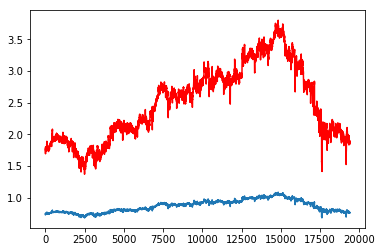

Pair: 6/7

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:               176022
Model:                     ARMA(5, 4)   Log Likelihood              600504.270
Method:                       css-mle   S.D. of innovations                nan
Date:                Thu, 04 Jul 2019   AIC                       -1200988.540
Time:                        15:52:39   BIC                       -1200887.756
Sample:                             0   HQIC                      -1200958.711
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.8832   4.29e-05   2.06e+04      0.000       0.883       0.883
ar.L2.y        0.4743   8.45e-05   5616.027      0.000       0.474       0.475
ar.L3.y       -0.2849      0.000  -2201.472      0.0

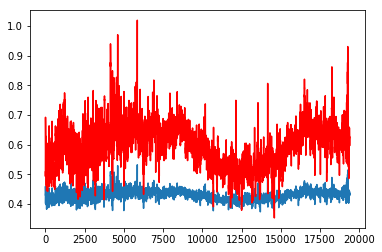

Pair: 7/7

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:               176022
Model:                     ARMA(5, 4)   Log Likelihood              717879.851
Method:                       css-mle   S.D. of innovations                nan
Date:                Thu, 04 Jul 2019   AIC                       -1435739.701
Time:                        15:59:14   BIC                       -1435638.918
Sample:                             0   HQIC                      -1435709.873
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.8238      0.000   5392.149      0.000       0.824       0.824
ar.L2.y        0.4135      0.000   1332.162      0.000       0.413       0.414
ar.L3.y       -0.1377        nan        nan        n

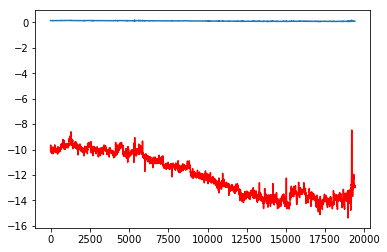

In [51]:
arima_predictions = []
for i, pair in enumerate(pairs):
    if i == 0:
        continue
    sys.stdout.write("\r"+'Pair: {}/{}'.format(i + 1, len(pairs)))
    sys.stdout.flush()
    spread_train = pair[2]['spread']
    spread_test = (pair[2]['Y_test'] - pair[2]['coint_coef']*pair[2]['X_test'])
    pair_predictions, error = static_ARIMA(spread_train, spread_test, 5, 0, 4)
    arima_predictions.append(pair_predictions)

Start model fitting...


/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Finished model fitting... Time elapsed:  425.7436988353729
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:               156516
Model:                    ARMA(10, 4)   Log Likelihood              200030.147
Method:                       css-mle   S.D. of innovations                nan
Date:                Thu, 04 Jul 2019   AIC                        -400030.295
Time:                        11:27:51   BIC                        -399880.881
Sample:                             0   HQIC                       -399985.846
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.6597      0.014     47.392      0.000       0.632       0.687
ar.L2.y        0.2242        nan        nan        nan         nan      

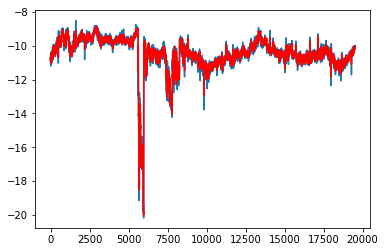

In [27]:
arima_static_predictions, error = static_ARIMA(example_spread, 10, 0, 4, train_val_split)

In [ ]:
p_grid = [3, 5, 10, 15]
q_grid = [3, 5]
best_predictions = None
best_error = 9999
for p in p_grid:
    for q in q_grid:
        print('------------')
        print('({},0,{}) score:'.format(p,q))
        predictions, error = static_ARIMA(example_spread, p, 0, q, train_val_split)
        if error < best_error:
            best_error = error
            best_predictions = predictions
            best_config = (p, 0, q)

In [213]:
print('Best configuration: ', best_config)

Best configuration:  (5, 0, 3)


In [38]:
print('RMSE for predicting the spread pct change is {}'.format(np.sqrt(0.023)))

RMSE for predicting the spread pct change is 0.15165750888103102


In [ ]:
# see persistent forecasting
# try with more delays

In [28]:
ret_example, cumret_example, summary_example = forecasting_trader.forecast_spread_trading(X=x_val, Y=y_val,
                                                               spread_test=spread_val,
                                                               spread_train=example_spread[:train_val_split],
                                                               beta=beta, 
                                                               predictions=arima_static_predictions,
                                                               lag=1)
print('Accumulated return: {} %'.format(cumret_example[-1]*100))
cumret_example.plot()

NameError: name 'x_val' is not defined

In [342]:
summary_example.head()#.trading_days[summary_example.trading_days!=0]

,position_during_day,predicted_change(%),predicted_direction,prediction(t),ret,ret_with_costs,spread(t),trading_days,true_direction
2017-01-03 14:35:00,0.0,0.000000,0,48.261079,0.0,0.0,48.647090,0,NaN
2017-01-03 14:40:00,0.0,-0.072367,-1,48.611886,0.0,0.0,48.703066,0,1
2017-01-03 14:45:00,0.0,-0.023043,-1,48.691844,0.0,0.0,48.718293,0,1
2017-01-03 14:50:00,0.0,-0.016692,-1,48.710161,0.0,0.0,48.239293,0,-1
2017-01-03 14:55:00,0.0,0.121253,1,48.297785,0.0,0.0,48.250338,0,1


In [318]:
summary_example['predicted_change(%)'][summary_example['predicted_change(%)']>0].sort_values(ascending=False).head()

2017-09-13 14:30:00    0.175065
2017-09-19 19:25:00    0.123547
2017-03-16 18:50:00    0.116855
2017-02-01 16:45:00    0.108065
2017-12-21 18:05:00    0.105310
Name: predicted_change(%), dtype: float64

# Trying some ANN based models

In [395]:
def plot_loss(history, title):
    """
    Function to plot loss function.
    Arguments:
    history: History object with data from training.
    title: Plot title.
    """
    
    plt.plot(history['loss'], label = "training")
    plt.plot(history['val_loss'], label = "validation")
    
def plot_predictions(summaries):
    
    n_pairs = len(summaries)
    fig, ax = plt.subplots(n_pairs, 1, figsize=(20,25))
    
    for i in range(n_pairs):
        #title('Pair: {}'.format(i))
        predictions = summaries[i]['prediction(t)']
        spread = summaries[i]['spread(t)']
        ax[i].plot(predictions, 'b')
        ax[i].plot(spread, 'r')
    return None

## MLP

In [28]:
def grid_search_MLP(X, y, validation_data, n_in, hidden_nodes, epochs, optimizer, loss_fct):
    """
    Funcion to perform grid search.
    """
    models = [] # saves parameters and score for every model
    best_model = {'neurons':0,'mse':9999,'mae':9999, 'history':None, 'predictions':None} 
    for i,neurons in enumerate(hidden_nodes):
        history, score, predictions = apply_MLP(X, y, validation_data, n_in, neurons, epochs,
                                                optimizer, loss_fct)
        
        # save reference to best model
        # score is loss! So being smaller is actually better
        if score['val'][1] < best_model['mae']:
            # update best model
            best_model['neurons']=neurons
            best_model['mse']=score['val'][0]
            best_model['mae']=score['val'][1]
            best_model['history']=history
            best_model['predictions']=predictions

        # simply save score
        # this way we save a bit of memory
        models.append({'neurons':neurons,
                       'mse':score['val'][0],
                       'mae':score['val'][1]
                      })
   
    print('The best model obtained a MAE score of ', best_model['mae'])
    
    return models, best_model    

# Grid Search

**Load models run in the server**

In [74]:
def read_models(path='models/'):
    all_models = [] # Creates an empty list
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".pkl"):
                with open(path+file, 'rb') as f:
                    models = pickle.load(f)
                all_models.append(models)
                
    return all_models

def run_trained_models(pairs, path, train_val_split='2017-01-01', lag=1, low_quantile=0.15, high_quantile=0.85):
    
    # initialize storage variables
    best_score = -99999
    best_model = None
    
    all_models = read_models(path)
    for configuration in all_models:#[:1]:
        config = configuration[-1]
        print('\n###################### NEW CONFIGURATION ######################')
        print('Configuration: ', config)
        configuration_cumret = list()
        for pair_i in range(len(configuration)-1):
            print('\nPair loaded: {}_{}:'.format(configuration[pair_i]['leg1'], configuration[pair_i]['leg2']))
            print('Check pairs: {}_{}.'.format(pairs[pair_i][0], pairs[pair_i][1]))
            predictions = configuration[pair_i]['predictions_val']
            ret, cumret, summary = forecasting_trader.forecast_spread_trading(
                                                       X=pairs[pair_i][2]['X_train'][train_val_split:],
                                                       Y=pairs[pair_i][2]['Y_train'][train_val_split:],
                                                       spread_test=pairs[pair_i][2]['spread'][train_val_split:],
                                                       spread_train=pairs[pair_i][2]['spread'][:train_val_split],
                                                       beta=pairs[pair_i][2]['coint_coef'],
                                                       predictions=predictions,
                                                       lag=lag,
                                                       low_quantile=low_quantile,
                                                       high_quantile=high_quantile)
            print('Accumulated return: {:.2f}%'.format(cumret[-1]*100))
            configuration_cumret.append(cumret[-1]*100)
        
        print('\nCONFIGURATION MEAN ROI: {:.2f}%'.format(np.mean(configuration_cumret)))
        if np.mean(configuration_cumret)>best_score:
            best_score = np.mean(configuration_cumret)
            best_model = config
    
    return all_models, (best_model, best_score)

**Define path below**

In [362]:
current_path = 'models_copy/mlp_7_pairs/'
with open(current_path+'pairs_unsupervised_learning_intraday.pickle', 'rb') as handle:
    pairs = pickle.load(handle)

In [ ]:
models, best = run_trained_models(pairs, path=current_path,
                                  low_quantile=0.05, high_quantile=0.95)

**Forecasting score**

In [129]:
best_score = display_forecasting_score(models)


###################### NEW CONFIGURATION ######################
Configuration:  {'train_val_split': '2017-01-01', 'hidden_nodes': [5, 5], 'epochs': 500, 'n_out': 1, 'loss_fct': 'mse', 'optimizer': 'adam', 'batch_size': 512, 'test_init': '2018-01-01', 'n_in': 5}

Pair loaded: PXE_PXI:

Pair loaded: DBA_RJZ:

Pair loaded: GCC_RJA:

Pair loaded: RJA_RJZ:
Pair RJA: Val MSE - 9.2138E-4

Pair loaded: DGP_UGL:

Pair loaded: DZZ_GLL:
Pair DZZ: Val MSE - 14.1798E-4

CONFIGURATION TRAIN MSE ERROR: 38.9408E-4
CONFIGURATION TRAIN MAE ERROR: 0.0332

CONFIGURATION VAL MSE ERROR: 43.3356E-4
CONFIGURATION VAL MAE ERROR: 0.0291

Epochs per pair: [216, 155, 500, 29, 1, 251]

###################### NEW CONFIGURATION ######################
Configuration:  {'train_val_split': '2017-01-01', 'hidden_nodes': [20], 'epochs': 500, 'n_out': 1, 'loss_fct': 'mse', 'optimizer': 'adam', 'batch_size': 512, 'test_init': '2018-01-01', 'n_in': 10}

Pair loaded: PXE_PXI:

Pair loaded: DBA_RJZ:

Pair loaded: GCC_RJA:

Pa

In [130]:
best_score

({'batch_size': 512,
  'epochs': 500,
  'hidden_nodes': [10],
  'loss_fct': 'mse',
  'n_in': 5,
  'n_out': 1,
  'optimizer': 'adam',
  'test_init': '2018-01-01',
  'train_val_split': '2017-01-01'},
 0.00262237100381084)

**Try trading using simple MLP model**

In [392]:
model, cumret, summaries_mlp = forecasting_trader.run_specific_model(10, [5], pairs, path=current_path,
                                                                     low_quantile=0.10, high_quantile=0.90, lag=1)

Long threshold: 6.46
Short threshold: -6.42
Accumulated return: 0.00%
Sharpe Ratio: 0
Long threshold: 5.25
Short threshold: -5.00
Accumulated return: 1.23%
Sharpe Ratio: 0.9438095362071958
Long threshold: 30.87
Short threshold: -30.28
Accumulated return: -1.77%
Sharpe Ratio: -0.2344408394406809
Long threshold: 6.25
Short threshold: -6.26
Accumulated return: 6.12%
Sharpe Ratio: 1.0408533561441866
Long threshold: 36.46
Short threshold: -32.15
Accumulated return: 0.00%
Sharpe Ratio: 0
Long threshold: 54.94
Short threshold: -48.31
Accumulated return: 6.13%
Sharpe Ratio: 0.9632030047120762
Long threshold: 7.48
Short threshold: -8.09
Accumulated return: -2.62%
Sharpe Ratio: -0.4670516109162212

Model mean ROI: 1.30%
Model mean Sharpe Ratio: 0.32


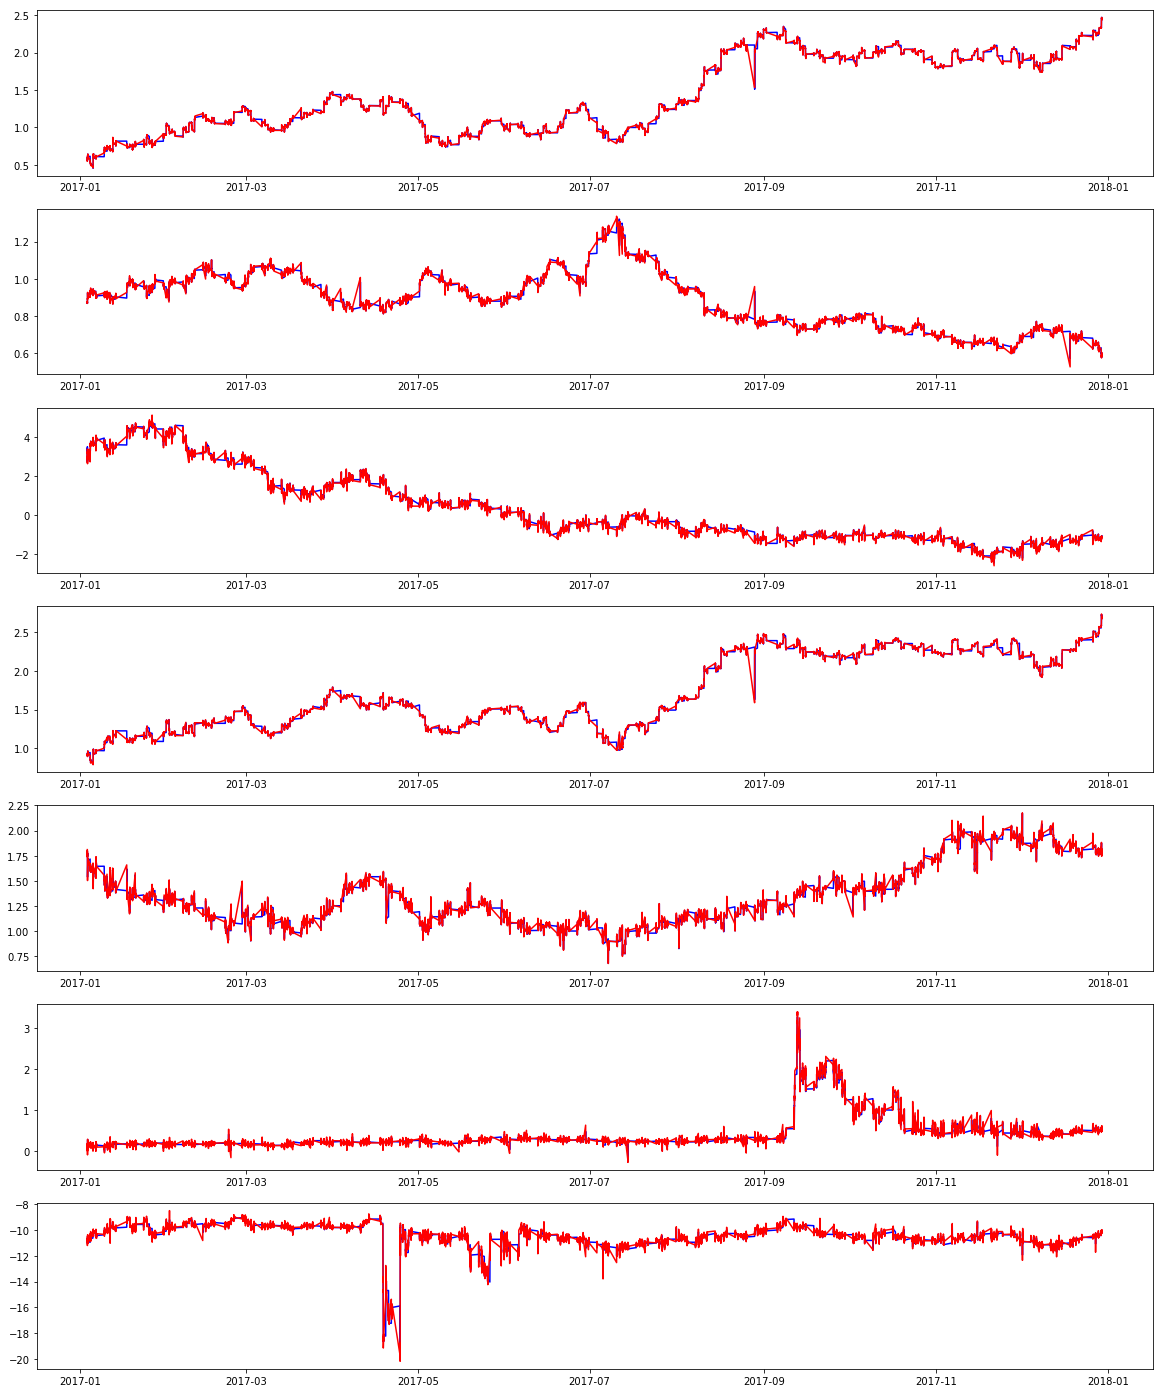

In [396]:
plot_predictions(summaries_mlp)

In [714]:
# perceber como é que melhora tanto quando eu baixo o threshold
# - ver accuracy da direção - parece ser a mesma para diferentes threhsolds.
# Para -70,70 a accuracy é muito boa mas as cum returns nem por isso. Por ter menos trades pode não compensar
# usar este parametro para treinar a rede possivelmente pode ser melhor - mudar para classificação
# criar threshold adaptativo

**Important:** On day n, I will make the prediction for day n, and not for day n+1. 

**MLP performance on test set**

In [232]:
model, cumret, summaries = run_specific_model(5, [10], pairs, path=current_path,
                                            low_quantile=0.05, high_quantile=0.95, lag=1)


Pair loaded: PXE_PXI:
Check pairs: PXE_PXI.
Long threshold: 50.00
Short threshold: -50.00
Accumulated return: -9.28%

Pair loaded: DBA_RJZ:
Check pairs: DBA_RJZ.
Long threshold: 13.62
Short threshold: -13.75
Accumulated return: 0.00%

Pair loaded: GCC_RJA:
Check pairs: GCC_RJA.
Long threshold: 9.43
Short threshold: -8.74
Accumulated return: 0.79%

Pair loaded: RJA_RJZ:
Check pairs: RJA_RJZ.
Long threshold: 12.01
Short threshold: -11.86
Accumulated return: 0.00%

Pair loaded: DGP_UGL:
Check pairs: DGP_UGL.
Long threshold: 50.00
Short threshold: -50.00
Accumulated return: -2.62%

Pair loaded: DZZ_GLL:
Check pairs: DZZ_GLL.
Long threshold: 13.44
Short threshold: -15.06
Accumulated return: 0.00%

Model mean ROI: -1.85%


In [220]:
cumret = np.asarray(cumret)
profitable_pairs_indices = np.argwhere(cumret > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]

In [221]:
model, cumret, summaries = test_specific_model(10, [5], pairs, path=current_path,
                                    low_quantile=0.10, high_quantile=0.90, lag=1,
                                    profitable_pairs_indices=profitable_pairs_indices)


Pair loaded: DBA_GCC:
Check pairs: DBA_GCC.
Long threshold: 5.00
Short threshold: -5.00
Accumulated return: 0.00%

Pair loaded: RJA_RJZ:
Check pairs: RJA_RJZ.
Long threshold: 5.95
Short threshold: -6.01
Accumulated return: 5.60%

Pair loaded: GSG_USL:
Check pairs: GSG_USL.
Long threshold: 12.43
Short threshold: -12.86
Accumulated return: -64.41%

Pair loaded: DZZ_GLL:
Check pairs: DZZ_GLL.
Long threshold: 7.07
Short threshold: -7.58
Accumulated return: 6.94%

Model mean ROI on test set: -12.97%


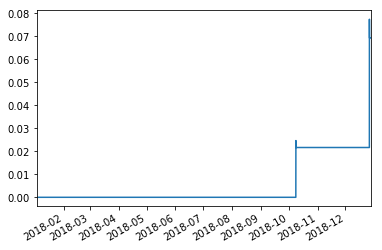

In [212]:
(np.cumprod(summaries[2].ret_with_costs +1)-1).plot()

# Modelling with more complex models

## RNN

In [246]:
hidden_nodes = [320]
model_config = {"n_in": 50,
                "n_out": 1,
                "epochs": 500,
                "hidden_nodes": [20],
                "loss_fct": "mse",
                "optimizer": "adam",
                "batch_size": 512,
                "train_val_split": '2017-01-01',
                "test_init": '2018-01-01'}

In [247]:
example = pairs[1]#[5]
example_spread = example[2]['spread']

# define data size - select one year for validation
train_val_split = '2017-01-01' # initial date

# normalize data
scaler = MinMaxScaler(feature_range = (0, 1))
example_spread_norm = scaler.fit_transform(example_spread.values.reshape(example_spread.shape[0],1)) 
example_spread_norm = pd.Series(data=example_spread_norm.flatten(), index=example_spread.index)

# spread validation
spread_val = example_spread[train_val_split:]

# prepare data
forecasting_data = forecasting_trader.series_to_supervised(list(example_spread_norm),
                                                           example_spread_norm.index,
                                                           model_config['n_in'],
                                                           1,
                                                           dropnan=True)

In [248]:
# define dataset
X_series = forecasting_data.drop(columns='var1(t)')
y_series = forecasting_data['var1(t)']

# split
X_series_train = X_series[:train_val_split]
X_series_val = X_series[train_val_split:]
y_series_train = y_series[:train_val_split]
y_series_val = y_series[train_val_split:]

X_train = X_series_train.values
X_val = X_series_val.values
y_train = y_series_train.values
y_val = y_series_val.values

In [249]:
# test data
example_spread_test = example[2]['Y_test']-example[2]['coint_coef']*example[2]['X_test']
example_spread_test_norm = scaler.transform(example_spread_test.values.reshape(example_spread_test.shape[0],1)) 
example_spread_test_norm = pd.Series(data=example_spread_test_norm.flatten(), index=example_spread_test.index)

forecasting_data_test = forecasting_trader.series_to_supervised(list(example_spread_test_norm),
                                                                example_spread_test_norm.index,
                                                                model_config['n_in'],
                                                                model_config['n_out'],
                                                                dropnan=True)
# define dataset
X_series_test = forecasting_data_test.drop(columns='var1(t)')
y_series_test = forecasting_data_test['var1(t)']

X_test = X_series_test.values
y_test = y_series_test.values

In [250]:
# train one configuration
start = time.time()
rnn_model, rnn_history, rnn_score, rnn_predictions_validation, rnn_predictions_test = \
                        forecasting_trader.apply_RNN(X_train, y_train,
                                                     validation_data=(X_val, y_val),
                                                     test_data=(X_test, y_test),
                                                     hidden_nodes=model_config['hidden_nodes'],
                                                     epochs=10,
                                                     optimizer=model_config['optimizer'],
                                                     loss_fct=model_config['loss_fct'])
end = time.time()
print('Finished model fitting... Time elapsed: ',(end - start))

rnn_predictions_validation_destandardized =  scaler.inverse_transform(rnn_predictions_validation)
rnn_predictions_validation_destandardized = pd.Series(data=rnn_predictions_validation_destandardized.flatten(),
                                       index=y_series_val.index)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 20)                1320      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 21        
Total params: 1,341
Trainable params: 1,341
Non-trainable params: 0
_________________________________________________________________
Train on 156466 samples, validate on 19506 samples
Epoch 1/10


KeyboardInterrupt: 

In [59]:
mean_squared_error(rnn_predictions_validation_destandardized, example_spread[train_val_split:])

0.0005713357756864794

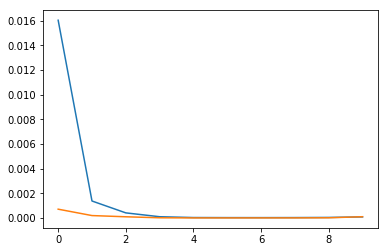

In [64]:
plot_loss(rnn_history.history, 'RNN Loss')

In [175]:
ret, cumret, summary = forecasting_trader.forecast_spread_trading(
                                                       X=example[2]['X_train'][train_val_split:],
                                                       Y=example[2]['Y_train'][train_val_split:],
                                                       spread_test=example[2]['spread'][train_val_split:],
                                                       spread_train=example[2]['spread'][:train_val_split],
                                                       beta=example[2]['coint_coef'],
                                                       predictions=rnn_predictions_validation_destandardized,
                                                       lag=1,
                                                       low_quantile=0.10,
                                                       high_quantile=0.90)
print(cumret[-1]*100)

14.648039231635268


In [69]:
for i in range(len(pairs)):
    print('{}-{}'.format(pairs[i][0], pairs[i][1]))

DBA-RJZ
GCC-RJA
PXE-PXI
RJA-RJZ
DBE-GSP
DGP-UGL
DZZ-GLL


## Grid Search

In [398]:
current_path=('models_copy/rnn_6_pairs/')
with open(current_path+'pairs_unsupervised_learning_intraday.pickle', 'rb') as handle:
    pairs = pickle.load(handle)
len(pairs)

6

In [85]:
rnn_models = read_models(path=current_path)

In [ ]:
best_forecast = forecasting_trader.display_forecasting_score(rnn_models)

**Validation**

In [202]:
model, cumret_val, summaries = forecasting_trader.run_specific_model(78, [20], pairs, path=current_path,
                                                  low_quantile=0.15, high_quantile=0.85, lag=1)

Accumulated return: -5.44%
Sharpe Ratio: -0.5363167803491962
Accumulated return: 1.23%
Sharpe Ratio: 0.8797548541141621
Accumulated return: 1.46%
Sharpe Ratio: 0.20344461972153366
Accumulated return: 0.00%
Sharpe Ratio: 0
Accumulated return: 0.00%
Sharpe Ratio: 0
Accumulated return: -1.74%
Sharpe Ratio: -0.13994738673995297

Model mean ROI: -0.75%
Model mean Sharpe Ratio: 0.07


**Test unrestricted**

In [203]:
model, cumret_test, summaries = forecasting_trader.test_specific_model(78, [20], pairs, path=current_path,
                                              low_quantile=0.15, high_quantile=0.85, lag=1, 
                                              profitable_pairs_indices=range(len(pairs)))


Pair loaded: DBA_RJZ:
Accumulated return: 18.81%
Sharpe Ratio: 1.283259592395479

Pair loaded: GCC_RJA:
Accumulated return: 1.46%
Sharpe Ratio: 1.5745197273263818

Pair loaded: PXE_PXI:
Accumulated return: 19.03%
Sharpe Ratio: 1.536079267673563

Pair loaded: RJA_RJZ:
Accumulated return: 0.00%
Sharpe Ratio: 0

Pair loaded: DBE_GSP:
Accumulated return: 0.00%
Sharpe Ratio: 0

Pair loaded: DGP_UGL:
Accumulated return: 0.00%
Sharpe Ratio: 0

Model mean ROI on test set: 6.55%
Model mean Sharpe Ratio on test set: 0.73


**Test with positive pairs on validation set**

In [399]:
cumret_val = np.asarray(cumret_val)
profitable_pairs_indices = np.argwhere(cumret_val > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]
model, cumret, summaries_rnn = forecasting_trader.test_specific_model(78, [20], pairs, path=current_path,
                                              low_quantile=0.15, high_quantile=0.85, lag=1, 
                                              profitable_pairs_indices=profitable_pairs_indices)


Pair loaded: GCC_RJA:
Long threshold: 5.00
Short threshold: -5.00
Accumulated return: 1.46%
Sharpe Ratio: 1.5745197273263818

Pair loaded: PXE_PXI:
Long threshold: 20.78
Short threshold: -20.50
Accumulated return: 19.03%
Sharpe Ratio: 1.536079267673563

Model mean ROI on test set: 10.25%
Model mean Sharpe Ratio on test set: 1.56


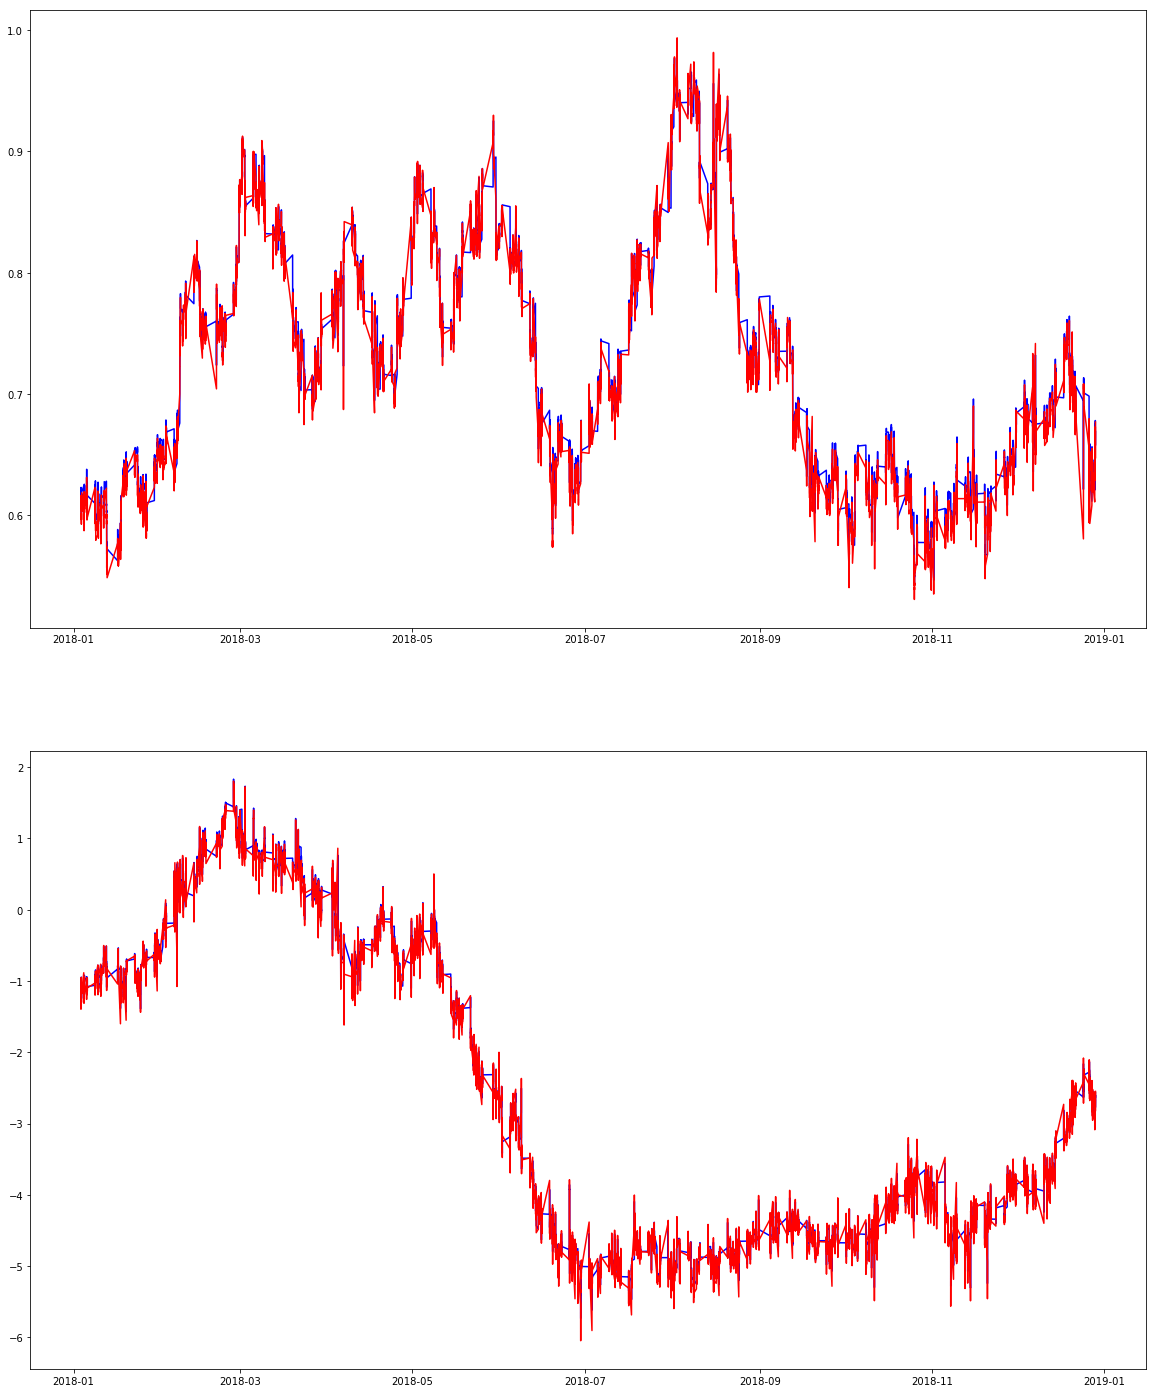

In [400]:
plot_predictions(summaries_rnn)

## Encoder-Decoder LSTM Multi-step Forecasting

In [256]:
from keras.layers import RepeatVector

def apply_encoder_decoder(X, y, validation_data, test_data, n_in, n_out, hidden_nodes,
                          epochs, optimizer, loss_fct):
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))
    y = y.reshape((y.shape[0], y.shape[1], 1))
    X_val = validation_data[0].reshape((validation_data[0].shape[0], validation_data[0].shape[1], 1))
    y_val = validation_data[1].reshape((validation_data[1].shape[0], validation_data[1].shape[1], 1))
    X_test = test_data[0].reshape((test_data[0].shape[0], test_data[0].shape[1], 1))
    y_test = test_data[1].reshape((test_data[1].shape[0], test_data[1].shape[1], 1))
    
    # define model
    model = Sequential()
    model.add(LSTM(hidden_nodes[0], activation='relu', input_shape=(n_in, 1)))
    model.add(RepeatVector(n_out))
    model.add(LSTM(hidden_nodes[1], activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer=optimizer, loss=loss_fct)
    model.summary()

    # fit model
    history = model.fit(X, y, epochs=epochs, verbose=1, validation_data=(X_val, y_val))
    
    # evaluate
    train_score = model.evaluate(X, y, verbose=0)
    val_score = model.evaluate(X_val, y_val, verbose=0)
    test_score = model.evaluate(X_test, y_test, verbose=0)
    score = {'train': train_score, 'val': val_score, 'test': test_score}
    
    # predict
    predictions_val = model.predict(X_val)
    predictions_test = model.predict(X_test)

    return model, history, score, predictions_val, predictions_test

In [349]:
model_config = {"n_in": 500,
                "n_out": 2,
                "epochs": 5,#10,
                "hidden_nodes":[10, 5] ,
                "loss_fct": "mse",
                "optimizer": "adam",
                "batch_size": 512,
                "train_val_split": '2017-01-01',
                "test_init": '2018-01-01'}

In [350]:
example = pairs[1]#[5]
example_spread = example[2]['spread']

# define data size - select one year for validation
train_val_split = '2017-01-01' # initial date

# normalize data
scaler = MinMaxScaler(feature_range = (0, 1))
example_spread_norm = scaler.fit_transform(example_spread.values.reshape(example_spread.shape[0],1)) 
example_spread_norm = pd.Series(data=example_spread_norm.flatten(), index=example_spread.index)

# spread validation
spread_val = example_spread[train_val_split:]

# prepare data
forecasting_data = forecasting_trader.series_to_supervised(list(example_spread_norm),
                                                           example_spread_norm.index,
                                                           model_config['n_in'],
                                                           model_config['n_out'],
                                                           dropnan=True)

In [351]:
# define dataset
X_series = forecasting_data.drop(columns=['var1(t)','var1(t+1)'])
y_series = forecasting_data[['var1(t)', 'var1(t+1)']]

# split
X_series_train = X_series[:train_val_split]
X_series_val = X_series[train_val_split:]
y_series_train = y_series[:train_val_split]
y_series_val = y_series[train_val_split:]

X_train = X_series_train.values
X_val = X_series_val.values
y_train = y_series_train.values
y_val = y_series_val.values

In [352]:
# test data
example_spread_test = example[2]['Y_test']-example[2]['coint_coef']*example[2]['X_test']
example_spread_test_norm = scaler.transform(example_spread_test.values.reshape(example_spread_test.shape[0],1)) 
example_spread_test_norm = pd.Series(data=example_spread_test_norm.flatten(), index=example_spread_test.index)

forecasting_data_test = forecasting_trader.series_to_supervised(list(example_spread_test_norm),
                                                                example_spread_test_norm.index,
                                                                model_config['n_in'],
                                                                model_config['n_out'],
                                                                dropnan=True)
# define dataset
X_series_test = forecasting_data_test.drop(columns=['var1(t)','var1(t+1)'])
y_series_test = forecasting_data_test[['var1(t)','var1(t+1)']]

X_test = X_series_test.values
y_test = y_series_test.values

In [353]:
# train one configuration
start = time.time()
encdec_model, encdec_history, encdec_score, encdec_predictions_val, encdec_predictions_test = \
                               apply_encoder_decoder(X_train, y_train,
                                                     validation_data=(X_val, y_val),
                                                     test_data=(X_test, y_test),
                                                     n_in=model_config['n_in'],
                                                     n_out=model_config['n_out'],
                                                     hidden_nodes=model_config['hidden_nodes'],
                                                     epochs=model_config['epochs'],
                                                     optimizer=model_config['optimizer'],
                                                     loss_fct=model_config['loss_fct'])
end = time.time()
print('Finished model fitting... Time elapsed: ',(end - start))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 10)                480       
_________________________________________________________________
repeat_vector_14 (RepeatVect (None, 2, 10)             0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 2, 5)              320       
_________________________________________________________________
time_distributed_13 (TimeDis (None, 2, 1)              6         
Total params: 806
Trainable params: 806
Non-trainable params: 0
_________________________________________________________________
Train on 156016 samples, validate on 19505 samples
Epoch 1/5
156016/156016 [==============================] - 1605s 10ms/step - loss: 0.0021 - val_loss: 3.2075e-05
Epoch 2/5
156016/156016 [==============================] - 1542s 10ms/step - loss: 6.8144e-05 - val_loss: 2.6547

In [354]:
predictions_val_transformed = []
for i in range(encdec_predictions_val.shape[1]):
    predictions_val_transformed.append(scaler.inverse_transform(encdec_predictions_val[:,i,:]))

predictions_val_transformed = np.asarray(predictions_val_transformed).reshape(encdec_predictions_val.shape[0],
                                                                              encdec_predictions_val.shape[1],
                                                                              1)
predictions_val_transformed = pd.DataFrame(data={'t':predictions_val_transformed[:,0,:].flatten(),
                                                 't+1':predictions_val_transformed[:,1,:].flatten()},
                                           index=y_series_val.index
                                          )

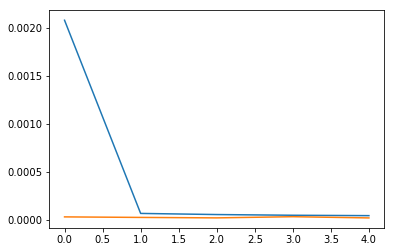

In [355]:
plot_loss(encdec_history.history, 'encoder_decoder_loss')

## CNN

In [228]:
def apply_CNN(X, y, validation_data, n_in, hidden_nodes, epochs, optimizer, loss_fct):
    # reshape data for conv net
    X = X.reshape((X.shape[0], X.shape[1], 1))
    X_val = validation_data[0].reshape((validation_data[0].shape[0], validation_data[0].shape[1], 1))
    y_val = validation_data[1]
    
   # define model
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=(n_in, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(hidden_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss_fct, metrics=['mae'])
    model.summary()
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    
    # fit model
    history = model.fit(X, y, epochs=epochs, verbose=0, validation_data=(X_val, y_val), callbacks=[es])
    train_score = model.evaluate(X, y, verbose=0)
    score = model.evaluate(X_val, y_val, verbose=0)
    predictions = model.predict(X_val)
    
    print('The mse train loss is: ', train_score[0])
    print('The mae train loss is: ', train_score[1])
    print('The mse test loss is: ', score[0])
    print('The mae test loss is: ', score[1])
    
    return history, score, predictions

In [229]:
# parameters
n_in = 5
epochs = 200
hidden_nodes = 20
loss_fct = 'mse'
optimizer = 'Adam'
train_val_split = int(0.66*len(example_spread))

In [230]:
# prepare data
forecasting_data = series_to_supervised(list(example_spread), example_spread.index, n_in, 1, dropnan=True)

# define dataset
X_series = forecasting_data.drop(columns='var1(t)')
y_series = forecasting_data['var1(t)']
X = np.asarray(forecasting_data.drop(columns='var1(t)').values)
y = np.asarray(forecasting_data[['var1(t)']].values)

# split
X_series_train = X_series[:train_val_split]
X_series_val= X_series[train_val_split:]
y_series_train = y_series[:train_val_split]
y_series_val = y_series[train_val_split:]

X_train = X[:train_val_split]
X_val = X[train_val_split:]
y_train = y[:train_val_split]
y_val = y[train_val_split:]

In [48]:
cnn_history, cnn_score, cnn_predictions = apply_CNN(X_train, y_train, (X_val, y_val), n_in,
                                                   hidden_nodes, epochs, optimizer, loss_fct)
cnn_predictions = pd.Series(data=cnn_predictions.flatten(), index=y_series_val.index)

NameError: name 'apply_CNN' is not defined

The mse test loss is:  0.02458564558011644
The mae test loss is:  0.11168607561027302


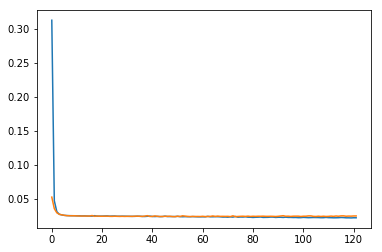

In [232]:
print('The mse test loss is: ', cnn_score[0])
print('The mae test loss is: ', cnn_score[1])
plot_loss(cnn_history, 'cnn_loss')

## CNN-LSTM

In [290]:
from keras.layers import TimeDistributed

def apply_CNN_LSTM(X, y, validation_data, n_in, hidden_nodes, epochs, optimizer, loss_fct):
    # reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
    X = X.reshape((X.shape[0], 2, 2, 1))
    X_val = validation_data[0].reshape((validation_data[0].shape[0], 2, 2, 1))
    y_val = validation_data[1]

    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='relu'), input_shape=(None, 2, 1)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(hidden_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss_fct, metrics=['mae'])
    model.summary()
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

    # fit model
    history = model.fit(X, y, epochs=epochs, verbose=0, validation_data=(X_val, y_val), callbacks=[es])
    train_score = model.evaluate(X, y, verbose=0)
    score = model.evaluate(X_val, y_val, verbose=1)
    predictions = model.predict(X_val)
    
    print('The mse train loss is: ', train_score[0])
    print('The mae train loss is: ', train_score[1])
    print('The mse test loss is: ', score[0])
    print('The mae test loss is: ', score[1])
    
    return history, score, predictions


In [291]:
# parameters
n_in = 4
epochs = 500
hidden_nodes = 50
loss_fct = 'mse'
optimizer = 'Adam'
train_val_split = int(0.8*len(example_spread))

In [292]:
# prepare data
forecasting_data = series_to_supervised(list(example_spread), example_spread.index, n_in, 1, dropnan=True)

# define dataset
X_series = forecasting_data.drop(columns='var1(t)')
y_series = forecasting_data['var1(t)']
X = np.asarray(forecasting_data.drop(columns='var1(t)').values)
y = np.asarray(forecasting_data[['var1(t)']].values)

# split
X_series_train = X_series[:train_val_split]
X_series_val= X_series[train_val_split:]
y_series_train = y_series[:train_val_split]
y_series_val = y_series[train_val_split:]

X_train = X[:train_val_split]
X_val = X[train_val_split:]
y_train = y[:train_val_split]
y_val = y[train_val_split:]

In [293]:
cnn_lstm_history, cnn_lstm_score, cnn_lstm_predictions = apply_CNN_LSTM(X_train, y_train, (X_val, y_val), n_in,
                                                                        hidden_nodes, epochs, optimizer, loss_fct)
cnn_lstm_predictions = pd.Series(data=cnn_lstm_predictions.flatten(), index=y_series_val.index)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_28 (TimeDis (None, None, 2, 32)       64        
_________________________________________________________________
time_distributed_29 (TimeDis (None, None, 1, 32)       0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, None, 32)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)                16600     
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 51        
Total params: 16,715
Trainable params: 16,715
Non-trainable params: 0
_________________________________________________________________
Epoch 00082: early stopping
399/399 [==============================] - 0s 54us/step
The mse train loss is:  0.02208408942411405
The mae tr

The mse test loss is:  0.03279840758999338
The mae test loss is:  0.12959755337178558


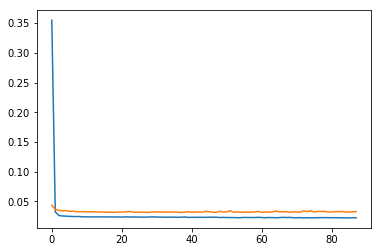

In [289]:
plot_loss(cnn_lstm_history, 'cnn_lstm_loss')

The mse test loss is:  0.0323833463092645
The mae test loss is:  0.12981718834629632


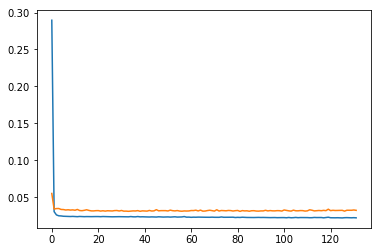

In [284]:
print('The mse test loss is: ', cnn_lstm_score[0])
print('The mae test loss is: ', cnn_lstm_score[1])
plot_loss(cnn_lstm_history, 'cnn_lstm_loss')

**Predictions**

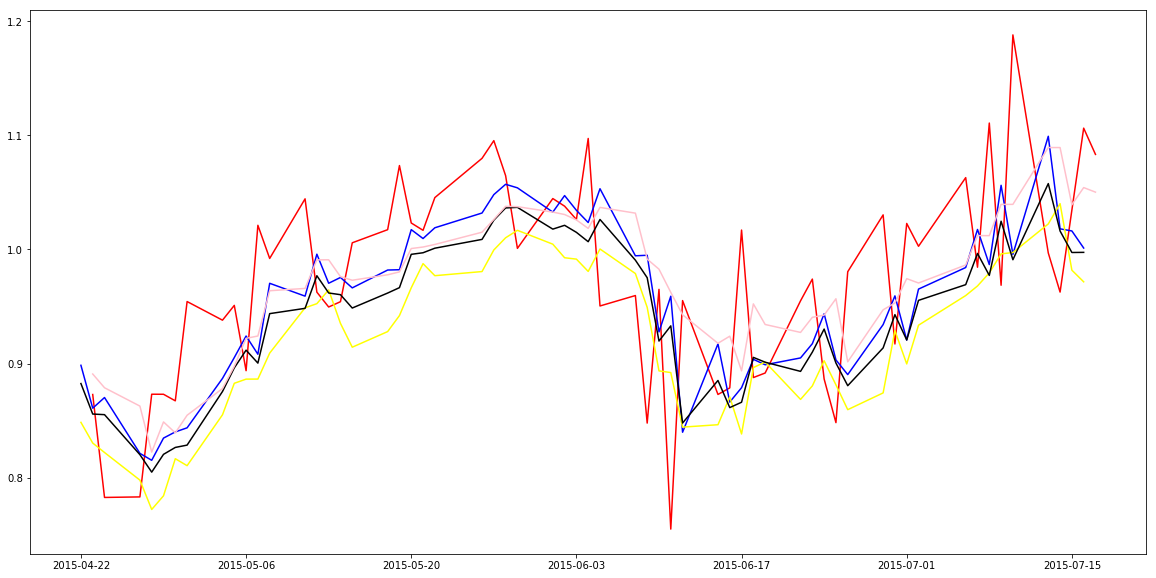

In [244]:
# Rerun y_test!

plt.close()
plt.figure(figsize=(20,10))
plt.plot(y_series_val[:60], color='red')
plt.plot(mlp_predictions[:60], color='blue')
plt.plot(cnn_predictions[:60], color='yellow')
plt.plot(rnn_predictions[:60], color='black')
plt.plot(cnn_lstm_predictions[:60], color='pink')
plt.show()

**Studying which variable is more meaningful when predicting the pnl**

From the table below, we can see that the spread change is way more indicative of the pnl (corr = 1), because everytime the spread changes the pnl changes the same way. On the other hand, returns simply by itself do not predict the pnl, because the value of X and Y still influence the outcome.

In [301]:
pairs[5]
pairs[5][2]
df = pd.DataFrame(data={'X_test':pairs[0][2]['X_test'], 'Y_test':pairs[0][2]['Y_test']})
# alternative 1
x_returns = -(pairs[0][2]['coint_coef'])*(df.X_test-df.X_test.shift(1))/df.X_test.shift(1)
y_returns = (df.Y_test-df.Y_test.shift(1))/df.Y_test.shift(1)
dunis_returns = x_returns + y_returns
df['dunis_returns/pnl']=dunis_returns
# alternative 2
spread = df.Y_test-(pairs[0][2]['coint_coef'])*df.X_test
spread_pct_change = (spread-spread.shift(1))/abs(spread.shift(1))
df['spread_pct_change'] = spread_pct_change
df['spread']=spread
# with normalized data
normalized_spread = (spread - spread.mean())/np.std(spread)
normalized_spread_pct_change = normalized_spread.pct_change()
#df['normalized_spread']=normalized_spread
df['normalized_spread_pct_change']=normalized_spread_pct_change
# other
df['pnl'] = df.X_test.shift(periods=1)*x_returns + df.Y_test.shift(periods=1)*y_returns
# regular returns
df['ret'] = df.pnl/(np.abs(df.X_test.shift(periods=1)*(pairs[0][2]['coint_coef']))+np.abs(df.Y_test.shift(periods=1)))
df

,X_test,Y_test,dunis_returns/pnl,spread_pct_change,spread,normalized_spread_pct_change,pnl,ret
2018-01-02,10.024570,21.0400,NaN,NaN,7.973652,NaN,NaN,NaN
2018-01-03,10.240998,21.3200,-0.014833,-0.000263,7.971552,0.003465,-0.002100,-0.000062
2018-01-04,10.260674,21.3900,0.000779,0.005564,8.015907,-0.072951,0.044355,0.001279
2018-01-05,10.211485,21.3800,0.005781,0.006751,8.070020,-0.096005,0.054114,0.001557
2018-01-08,10.270511,21.4900,-0.002389,0.004097,8.103084,-0.064889,0.033064,0.000953
2018-01-09,10.447589,21.7500,-0.010374,0.003602,8.132275,-0.061265,0.029191,0.000837
2018-01-10,10.516453,21.8700,-0.003074,0.003719,8.162516,-0.067610,0.030241,0.000855
2018-01-11,10.536128,21.9500,0.001219,0.006659,8.216871,-0.130333,0.054355,0.001528
2018-01-12,10.683693,22.1400,-0.009599,-0.000285,8.214530,0.006454,-0.002341,-0.000066
2018-01-16,10.595154,22.0300,0.005834,0.000658,8.219934,-0.014805,0.005404,0.000150


In [302]:
df.pnl.corr(df.spread_pct_change)

0.9946504653335959

In [303]:
df.spread_pct_change.corr(df.ret)

0.9997079157457316

In [259]:
df.normalized_spread_pct_change.corr(df.ret)

0.0388750160893099

It thus make totally sense to predict the spread percentage change, assuming we buy the stock at its current price. However, if we consider we always put 1$ on each side of the trade, the scenario shifts.

In [309]:
pairs[5]
pairs[5][2]
df = pd.DataFrame(data={'X_test':pairs[0][2]['X_train'][train_val_split:],
                        'Y_test':pairs[0][2]['Y_train'][train_val_split:]})
# alternative 1
x_returns = -(pairs[0][2]['coint_coef'])*(df.X_test-df.X_test.shift(1))/df.X_test.shift(1)
y_returns = (df.Y_test-df.Y_test.shift(1))/df.Y_test.shift(1)
dunis_returns = x_returns + y_returns
df['dunis_returns/pnl']=dunis_returns
# alternative 2
spread = df.Y_test-(pairs[0][2]['coint_coef'])*df.X_test
spread_pct_change = (spread-spread.shift(1))/abs(spread.shift(1))
df['spread_pct_change'] = spread_pct_change
df['spread']=spread
# with normalized data
normalized_spread = (spread - spread.mean())/np.std(spread)
normalized_spread_pct_change = normalized_spread.pct_change()
#df['normalized_spread']=normalized_spread
df['normalized_spread_pct_change']=normalized_spread_pct_change
# other
df['pnl'] = df.X_test.shift(periods=1)*x_returns + df.Y_test.shift(periods=1)*y_returns
# regular returns
df['ret'] = df.pnl/(np.abs(df.X_test.shift(periods=1)*(pairs[0][2]['coint_coef']))+np.abs(df.Y_test.shift(periods=1)))
df

,X_test,Y_test,dunis_returns/pnl,spread_pct_change,spread,normalized_spread_pct_change,pnl,ret
2015-04-15,14.372813,26.7300,NaN,NaN,7.996011,NaN,NaN,NaN
2015-04-16,14.549891,27.0800,-0.002965,0.014906,8.115202,0.109258,0.119191,0.002622
2015-04-17,14.490865,26.9300,-0.000251,-0.009003,8.042139,-0.060378,-0.073064,-0.001587
2015-04-20,14.589242,27.1100,-0.002165,0.006438,8.093912,0.045533,0.051773,0.001130
2015-04-21,14.412164,26.7500,0.002541,-0.015962,7.964720,-0.108672,-0.129191,-0.002801
2015-04-22,14.500703,26.8000,-0.006138,-0.008212,7.899316,-0.061724,-0.065404,-0.001436
2015-04-23,14.687618,27.2800,0.001109,0.029923,8.135684,0.237743,0.236368,0.005172
2015-04-24,14.736806,27.3100,-0.003265,-0.004193,8.101571,-0.027721,-0.034114,-0.000735
2015-04-27,14.648268,27.1300,0.001240,-0.007973,8.036975,-0.053988,-0.064596,-0.001389
2015-04-28,14.638430,27.0700,-0.001336,-0.005870,7.989798,-0.041680,-0.047177,-0.001021


In [310]:
df.spread_pct_change.corr(df.ret)

0.989613730214564